# Wine Quality Prediction with Text and Non-text Data
Last editing date: 2020.09.28. [GitHub](https://github.com/YC-1412/AML_projects/tree/master/NLP-wine_quality_prediction)

This project is modified from a homework I did with one of my classmates (Bo Jumrustanasan) on the course COMS 4995 Applied Machine Learning by Dr. Andreas C. Müller at Columbia University. The aim is to predict the wine points in a [wine review dataset](https://www.kaggle.com/zynicide/wine-reviews). The project includes the following parts:

1. data visualization
2. data preprocessing and imputation using pipelines
3. grid search on Linear Regression, Elastic Net, and LinearSVR to build a baseline linear model
4. modeling with text features using Bag of Words (BoW) and word-embedding

The final model is a Linear Regression model with BoW and word-embedding. The test accuracy is 77%.

# Load packages and data


In [36]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno
from scipy.sparse import hstack
%matplotlib inline

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# !pip install category_encoders
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import spacy
import re
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# import data
file_path = './data/'
sample = pd.read_csv(file_path + 'winemag-data-130k-v2.csv')
sample = sample[sample.country == 'US']

# 1. Visualization

In [4]:
# percent missing in each feature
missing_per=(sample.isnull().sum()[sample.isnull().sum()>0]/sample.shape[0]).sort_values(axis='index',ascending=False)*100
print("missing percentage (%):\n{}".format(missing_per))

missing percentage (%):
taster_twitter_handle    36.259724
designation              32.283869
taster_name              30.775723
region_2                  7.326068
region_1                  0.510054
price                     0.438500
dtype: float64


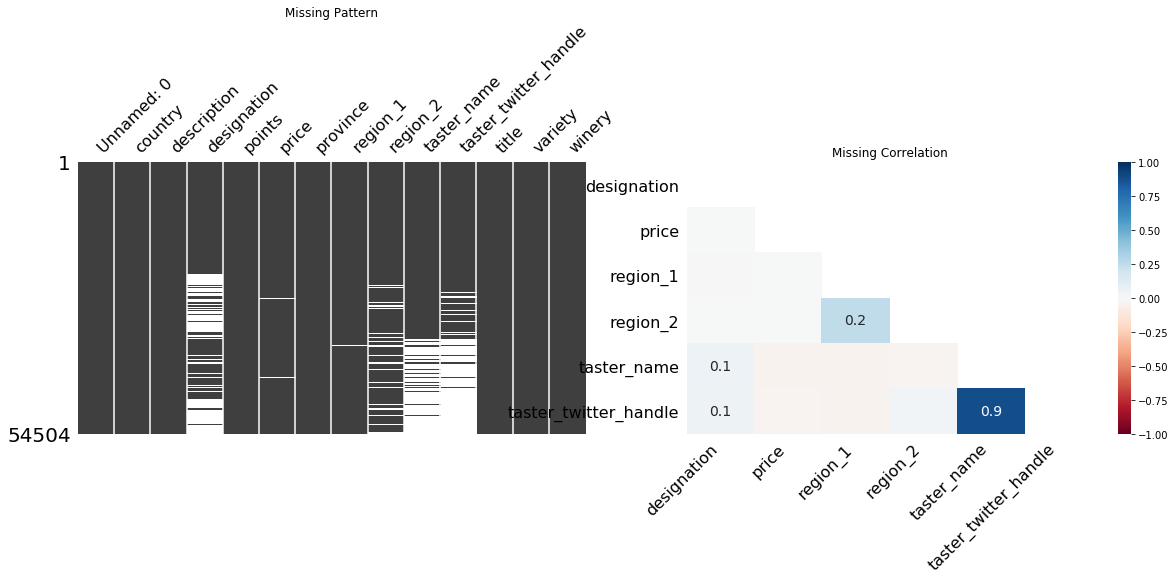

In [8]:
# White = missing, Ideally want 0 missing correlation
fig,ax = plt.subplots(1,2, figsize=(20,5))
msno.matrix(sample, sort="descending", sparkline=False, ax=ax[0])
msno.heatmap(sample, figsize=(10,5), ax=ax[1])
ax[0].set_title('Missing Pattern');
ax[1].set_title('Missing Correlation');

In [9]:
drop = ['Unnamed: 0','designation','taster_twitter_handle','country']    # features never use
sample = sample.drop(drop,1)

In [10]:
text = ['description','title']
categorical1 = ['province','taster_name','variety']
categorical2 = ['region_1','region_2','winery']          # categorical features not use for now
continuous = ['price']

In [2]:
def plot_eda(data, cols=3, width=20, height=25, hspace=0.2, wspace=0.5):
    '''
    plot boxplot for categorical features, and histogram for numeric features
    '''
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(data.shape[1] / cols)
    for i, feature in enumerate(data.columns):
        ax = fig.add_subplot(rows, cols, i + 1)

        if data.dtypes[feature] == np.object:
            # g = sns.countplot(y=feature, data=data)
            g = sns.boxplot(x='points', y=feature, data=data)
            plt.xticks(rotation=25)
            ax.set_title('{} vs points'.format(feature))
        else:
            g = sns.distplot(data[feature])
            # g = sns.scatterplot(x='points', y=feature, data=data)
            plt.xticks(rotation=25)
            ax.set_title(feature)
    
plot_eda(sample[['points','price','province','taster_name']], cols=2, width=15, height=15, hspace=0.3, wspace=0.5)

# 2. Baseline model (Linear Regression)
In this session we implemented and compared different preprocessing method, tried including different features, and did GridSearch on different linear models. The baseline model is Linear Regression with a 45% validation accuracy.
## 2.1 Preprocessing
Based on the missing pattern and preview of the features, we did the following data preprocessing:
1. dropped `Unnamed: 0`, `designation`, `taster_twitter_handle`, `country` because they are unrelated to `price` in this task
2. dropped or imputed missing values in `taster_name` with 'unknown' category 

Then we tried the following preprocessing model tuning steps:
1. included different features in the model
2. one-hot encoded or target encoded on different combination of categorical features; standardized numeric features
3. imputed `taster_name` or used complete cases or drop it
4. grid search on Linear Regression, Elastic Net, and LinearSVR

The best feature combination and preprocessing is:
* impute: `taster_name`
* one-hot encode: `region_1`, `region_2`, `taster_name`
* target encode: `winery`
* standardize: `price`

## 2.2 Define functions

In [12]:
def complete_cases(X, y, imputed_col = []):
    """
    Drop rows that contain missing values in cols that will never be imputed.
    
    Args:
      X, y: paired data whose indices align.
      dropped_col: column names to be dropped.
      imputed_col: columns names that will later be imputed.
    Return:
      X_complete, y_complete: complete-cased X and y.
    """
    other_col = list(set(X.columns).difference(imputed_col))
    keep = ~X[other_col].isna().any(axis=1)
    X_complete = X[keep]
    y_complete = y[keep]
    return X_complete, y_complete

In [14]:
def pipe_preprocess(impute=True, continuous=[], target=[], categorical=[], remainder=True):
    """
    Create preprocess pipeline for non_text features (continuous, target, categorical, and other non_text features).
    Agrs:
    impute: boolean variable. True: impute, False: not impute
    continuous, target, categorical: list of corresponding column names
    remainder: boolean variable. True: keep other columns, False: drop other columns
    Return:
    pipeline doing preprocess on non_text features
    """
    if impute:
        cat_preprocessing = Pipeline([('cat_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='most_frequent')),
                                      ('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])

        cont_preprocessing=Pipeline([('cont_imp',SimpleImputer(missing_values=np.nan, 
                                                               strategy='mean')),
                                     ('cont_pre',StandardScaler())])
    else:
        cat_preprocessing = Pipeline([('cat_pre',OneHotEncoder(handle_unknown ='ignore'))])
        cont_preprocessing = Pipeline([('cont_pre',StandardScaler())])
        
    if remainder:
        preprocess = make_column_transformer((cat_preprocessing,categorical),
                                             (cont_preprocessing,continuous),
                                             (TargetEncoder(),target),
                                             remainder='passthrough')
    else:
        preprocess = make_column_transformer((cat_preprocessing,categorical),
                                             (cont_preprocessing,continuous),
                                             (TargetEncoder(),target))
    return preprocess

In [15]:
def grid_result(param_grid, X_trainval, y_trainval, preprocess, cv=3):
    """
    Process and apply a grid search on X_trainval and y_trainval.
    Args:
    param_grid: dictionary of parameter settings to be grid searched on
    X_trainval, y_trainval: training and validation data
    preprocess: preprocess pipeline
    cv; # of cross-validation fold
    Return:
    grid object that is fitted on X_trainval and y_trainval
    """
    pipeline = Pipeline([('preprocess',preprocess),
                         ('regressor',LinearRegression())])

    grid = GridSearchCV(pipeline, param_grid, return_train_score=True, cv=cv)
    grid.fit(X_trainval, y_trainval)
    return grid

## 2.3 Build baseline model

In [19]:
text=['description','title']
one_hot_encode=['region_1','region_2','taster_name']
target_encode=['winery','province','variety'] 
continuous=['price']

# Split into train and test
y=sample.points
X=sample.drop(['points']+text,1)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=1)

# impute taster_name
impute_col = one_hot_encode + target_encode + continuous
X_trainval.taster_name.fillna('unknown', inplace = True)
X_trainval, y_trainval = complete_cases(X_trainval,y_trainval,imputed_col=impute_col)

# param_grid=[{'regressor':[LinearRegression()]}]
param_grid=[{'regressor':[LinearRegression()]},
            {'regressor':[ElasticNet(tol=1)],
             'regressor__alpha': np.logspace(-1,1,3),
             'regressor__l1_ratio': [0, .1, .5, .98, 1]},
            {'regressor':[LinearSVR(tol=1)],
             'regressor__C':np.logspace(-5,1,7)}]

preprocess = pipe_preprocess(impute=True, 
                             continuous=continuous, target=target_encode, categorical=one_hot_encode)
grid = grid_result(param_grid, X_trainval, y_trainval, preprocess, cv=3)
print("The baseline model is {model}\n The validation score is {score}\n"
      .format(score=grid.best_score_,model=grid.best_params_))

The baseline model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
 The validation score is 0.4477297278531387



# 3. Text-based model

In this session we explored the following methods to build a text-based model:

1. grid searched on different linear models
2. process text features using bag-of-words (BoW) and normalization approach. Grid searched on different vectorizers such as n-grams, characters, and tf-idf, as well as different settings of the parameters "ngram_range" and "min_df" (only the best result is shown)
2. process text features using word-embedding approach.

The best model is Linear Regression with both word embedding and tf-idf BoW approach (min_df = 50, ngram_range = (1,3)). The best validation accuracy is 76%.



## 3.1 Define functions

In [20]:
def text_preprocess(text, vect, non_text_pipe=[]):
    """
    Create preprocess pipeline for text features ('description' and 'title').
    Args:
    text: array of names of text features
    vect: vectorizer
    non_text_pipe: preprocess pipeline for non_text feature
    Return:
    preprocess pipeline for all features
    """
    if non_text_pipe==[]:
        if len(text)==2:
            # hstack two text columns
            preprocess = FeatureUnion([('text_d',Pipeline([('d',FunctionTransformer(lambda x: x['description'],validate=False)),
                                                           ('vectorizer',vect)])),
                                       ('text_t',Pipeline([('t',FunctionTransformer(lambda x: x['title'],validate=False)),
                                                           ('vectorizer',vect)]))])
        else:
            preprocess = FeatureUnion([('text_d',Pipeline([('d',FunctionTransformer(lambda x: x[text[0]],validate=False)),
                                                           ('vectorizer',vect)]))])
    else:
        # hstack two text columns and non-text columns
        if len(text)==2:
            preprocess = FeatureUnion([('text_d',Pipeline([('d',FunctionTransformer(lambda x: x['description'],validate=False)),
                                                           ('vectorizer',vect)])),
                                       ('text_t',Pipeline([('t',FunctionTransformer(lambda x: x['title'],validate=False)),
                                                           ('vectorizer',vect)])),
                                       ('non_text',non_text_pipe)])
        else:
            preprocess = FeatureUnion([('text_d',Pipeline([('d',FunctionTransformer(lambda x: x[text[0]],validate=False)),
                                                           ('vectorizer',vect)])),
                                       ('non_text',non_text_pipe)])
    return preprocess

In [44]:
# grid search vectorizer
def vectorize(analyzer, min_df, ngram_range, X_trainval, y_trainval, param_grid, non_text_pipe=[], tokenizer=None):
    """
    grid search using with different vectorizer (n-grams, character, tf-idf)
    Dependency:
    grid_result: called internally to do grid search
    Args:
    analyzer: indicating which vectorizer to use, has to be 'n-grams' or 'character', or 'tf-idf'
    min_df, ngram_range, tokenizer: vectorizer parameters
    X_trainval, y_trainval: training and validation data
    param_grid: dictionary of parameter settings to be grid searched on
    non_text_pipe: preprocess pipeline for non_text feature
    """
    for param in min_df:
        if analyzer == 'n-grams':
            vect = CountVectorizer(stop_words='english', min_df=param, ngram_range=ngram_range, tokenizer=tokenizer)
        elif analyzer == 'char':
            vect = CountVectorizer(min_df=param, ngram_range=ngram_range, analyzer="char", tokenizer=tokenizer)
        elif analyzer == 'tfidf': 
            vect = TfidfVectorizer(stop_words='english', min_df=param, ngram_range=ngram_range, tokenizer=tokenizer)

        preprocess = text_preprocess(text, vect, non_text_pipe=non_text_pipe)
        grid = grid_result(param_grid, X_trainval, y_trainval, preprocess, cv=3)
        feature_len=len(grid.best_estimator_.named_steps['regressor'].coef_)
        non_text = 'without' if non_text_pipe==[] else 'with'
        print("=======\n # Feature={feature}. min_df= {min_df}. ngram_range={ngram_range}. Analyzer is {analyzer}."
              .format(feature=feature_len,
                      analyzer=analyzer,
                      min_df=param,
                      ngram_range=ngram_range))
        print("Best validation score is {score}\nBest model is {model} {non_text} features."
              .format(score=grid.best_score_,
                      model=grid.best_params_,
                      non_text=non_text))

## 3.2 BoW model

Processing `descripton` and `title` using BoW gave a 71% validation accuracy. Including previous non-text features improved the accuracy to 75%, which means that the non-text features alone are sufficient enough to predict the wine quality.

In [45]:
# Split into train and test
y=sample.points
X=sample.drop(['points'],1)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=1)

# impute taster_name
impute_col = one_hot_encode + target_encode + continuous
X_trainval.taster_name.fillna('unknown', inplace = True)
X_trainval, y_trainval = complete_cases(X_trainval,y_trainval,imputed_col=impute_col)

In [46]:
param_grid=[{'regressor':[LinearRegression()]}]

# not include non_text features
non_text_pipe = []
vectorize('tfidf', [20,30,50,70,100], (1,3), 
          X_trainval, y_trainval, 
          param_grid, non_text_pipe = non_text_pipe, tokenizer=None)

# include non_text features
non_text_pipe = pipe_preprocess(impute=True, 
                                continuous=continuous, target=target_encode, categorical=one_hot_encode, 
                                remainder=False)
vectorize('tfidf', [50], (1,3), 
          X_trainval, y_trainval, 
          param_grid, non_text_pipe=non_text_pipe, tokenizer=None)

 # Feature=13281. min_df= 20. ngram_range=(1, 3). Analyzer is tfidf.
Best validation score is 0.6898740338825169
Best model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)} without features.
 # Feature=8713. min_df= 30. ngram_range=(1, 3). Analyzer is tfidf.
Best validation score is 0.7098959535600295
Best model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)} without features.
 # Feature=5177. min_df= 50. ngram_range=(1, 3). Analyzer is tfidf.
Best validation score is 0.7111166049195167
Best model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)} without features.
 # Feature=3732. min_df= 70. ngram_range=(1, 3). Analyzer is tfidf.
Best validation score is 0.7049054268520116
Best model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)} without features.
 # Feature=2643. min_df= 100. ngram_range=(

## 3.3 Tuning BoW model: tokenization

Tokenization did not improve the model for this dataset.

In [32]:
def tokenization(strings):
    '''
    Keep only alphanumeric characters in the text and do stemming
    '''
    words = re.sub(r"[^A-Za-z0-9\-]", " ", strings).lower().split()
    words = [token.lemma_ for token in nlp(strings)]
    return words

In [33]:
import en_core_web_lg
# !python -m spacy download en_core_web_lg
nlp = en_core_web_lg.load(disable=["tagger","parser","ner"])
# nlp = spacy.load("en_core_web_lg",disable=["tagger","parser","ner"])

In [52]:
vectorize('tfidf', [50], (1,3), 
          X_trainval, y_trainval, 
          param_grid, non_text_pipe=non_text_pipe, tokenizer=tokenization)

## 3.4 Word-embedding model

Word-embedding model alone did not help to predict wine quality, but together with BoW, the model achieve a test accuracy of 77%.

In [38]:
# word embedding
def nlp_vectorize(X):
    '''
    implement word embedding on input text
    '''
    docs_train_d = [nlp(d).vector for d in X]
    X_train_d = np.vstack(docs_train_d)
    return X_train_d

In [47]:
text = ['description','text']

# Split into train and test
y=sample.points
X=sample.drop(['points'],1)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=1)

# impute taster_name
impute_col = one_hot_encode + target_encode + continuous
X_trainval.taster_name.fillna('unknown', inplace=True)
X_trainval, y_trainval = complete_cases(X_trainval,y_trainval,imputed_col=impute_col)

vect = FunctionTransformer(nlp_vectorize)
vect_bow = TfidfVectorizer(stop_words='english', min_df=50, ngram_range=(1,3), tokenizer=None)

preprocess = FeatureUnion([('text_d',Pipeline([('d',FunctionTransformer(lambda x: x['description'],validate=False)),
                                               ('vectorizer',vect)])),
                           ('text_t_bow',Pipeline([('t',FunctionTransformer(lambda x: x['title'],validate=False)),
                                               ('vectorizer',vect_bow)])),
                           ('text_d_bow',Pipeline([('d',FunctionTransformer(lambda x: x['description'],validate=False)),
                                                   ('vectorizer',vect_bow)])),
                           ('non_text',non_text_pipe)])

grid = grid_result(param_grid, X_trainval, y_trainval, preprocess, cv=3)
feature_len=len(grid.best_estimator_.named_steps['regressor'].coef_)
score = grid.score(X_test, y_test)
print("# Feature={feature}.\n Validation score is {val_score}\n Test score is {test_score}\n Model is {model}"
      .format(feature=feature_len,
              val_score=grid.best_score_,
              test_score=score,
              model=grid.best_params_))

# Feature=5772.
 Validation score is 0.7634534022149175
 Test score is 0.7741161296951091
 Model is {'regressor': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)}
